In [34]:
from keras.api.applications import EfficientNetB3
from keras import layers
import keras
import json
import pandas as pd
import tensorflow
import numpy as np

### Load TACO dataset into a dataframe
Loading code provided via https://github.com/pedropro/TACO/blob/master/demo.ipynb

In [35]:
anns_file_path = './data/annotations.json'

# Read annotations
with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())

categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

# Load categories and super categories
cat_names = []
super_cat_names = []
super_cat_ids = {}
super_cat_last_name = ''
nr_super_cats = 0
for cat_it in categories:
    cat_names.append(cat_it['name'])
    super_cat_name = cat_it['supercategory']
    # Adding new super category
    if super_cat_name != super_cat_last_name:
        super_cat_names.append(super_cat_name)
        super_cat_ids[super_cat_name] = nr_super_cats
        super_cat_last_name = super_cat_name
        nr_super_cats += 1

map_cat_to_super_cat = {cat['name']: cat['supercategory'] for cat in categories}
data = []

# Create a DataFrame with category information
for img in imgs:
    img_id = img['id']
    img_annotations = [ann for ann in anns if ann['image_id'] == img_id]
    img_categories = [categories[ann['category_id'] - 1]['name'] for ann in img_annotations]
    img_super_categories = list(set([map_cat_to_super_cat[cat] for cat in img_categories]))
    data.append({
        'file_name': img['file_name'],
        'super_categories': ','.join(img_super_categories)
    })

df = pd.DataFrame(data)
df

,file_name,super_categories
0,batch_1/000006.jpg,Bottle
1,batch_1/000008.jpg,Carton
2,batch_1/000010.jpg,Bottle
3,batch_1/000019.jpg,"Bottle,Can"
4,batch_1/000026.jpg,Can
...,...,...
1495,batch_9/000095.jpg,"Carton,Plastic bag & wrapper,Squeezable tube,S..."
1496,batch_9/000096.jpg,Squeezable tube
1497,batch_9/000097.jpg,"Bottle,Bottle cap"
1498,batch_9/000098.jpg,"Carton,Bottle"


Resizing the images to match model resolution limits

In [36]:
RESOLUTION = 300
size = (RESOLUTION, RESOLUTION)

def resize(file):
    image = tensorflow.io.read_file('./data/' + file)
    image = tensorflow.image.decode_jpeg(image, channels=3)
    image = tensorflow.image.resize(image, size)
    return image

df['image'] = df['file_name'].map(resize)
df

,file_name,super_categories,image
0,batch_1/000006.jpg,Bottle,"(((tf.Tensor(77.80239, shape=(), dtype=float32..."
1,batch_1/000008.jpg,Carton,"(((tf.Tensor(249.97665, shape=(), dtype=float3..."
2,batch_1/000010.jpg,Bottle,"(((tf.Tensor(226.90001, shape=(), dtype=float3..."
3,batch_1/000019.jpg,"Bottle,Can","(((tf.Tensor(79.10309, shape=(), dtype=float32..."
4,batch_1/000026.jpg,Can,"(((tf.Tensor(43.20309, shape=(), dtype=float32..."
...,...,...,...
1495,batch_9/000095.jpg,"Carton,Plastic bag & wrapper,Squeezable tube,S...","(((tf.Tensor(9.639999, shape=(), dtype=float32..."
1496,batch_9/000096.jpg,Squeezable tube,"(((tf.Tensor(21.573334, shape=(), dtype=float3..."
1497,batch_9/000097.jpg,"Bottle,Bottle cap","(((tf.Tensor(5.0, shape=(), dtype=float32), tf..."
1498,batch_9/000098.jpg,"Carton,Bottle","(((tf.Tensor(5.0, shape=(), dtype=float32), tf..."


Excluding: Lid, Styrofoam piece, Blister pack, Battery

Add classes with broader scopes to match the TrashNET dataset. Drop None values to refine set.

In [38]:
label_dict = {
    # Paper
    0: ["Carton", "Paper", "Paper bag"],
    # Glass
    1: ["Bottle", "Bottle cap", "Broken glass", "Glass jar"],
    # Plastic
    2: ["Plastic bag & wrapper", "Bottle cap" "Other plastic", "Cup", "Straw", "Plastic container", "Plastic utensils", "Plastic glooves", "Squeezable tube"],
    # Metal
    3: ["Can", "Pop tab", "Alumininum foil", "Scrap metal"],
    # Cardboard
    4: ["Carton"],
    # Trash (misc)
    5: ["Cigarette", "Unlabeled litter", "Rope & strings", "Food waste", "Shoe"]
}

reverse_label_dict = {item: key for key, values in label_dict.items() for item in values}

# def relabel(super_cat):
#     for index in label_dict:
#         if super_cat in label_dict[index]:
#             return index
        
def relabel_all(cats):
    return [reverse_label_dict.get(cat) for cat in cats.split(',') if reverse_label_dict.get(cat) is not None]

df['label'] = df['super_categories'].map(relabel_all)
df

,file_name,super_categories,image,label
0,batch_1/000006.jpg,Bottle,"(((tf.Tensor(77.80239, shape=(), dtype=float32...",[1]
1,batch_1/000008.jpg,Carton,"(((tf.Tensor(249.97665, shape=(), dtype=float3...",[4]
2,batch_1/000010.jpg,Bottle,"(((tf.Tensor(226.90001, shape=(), dtype=float3...",[1]
3,batch_1/000019.jpg,"Bottle,Can","(((tf.Tensor(79.10309, shape=(), dtype=float32...","[1, 3]"
4,batch_1/000026.jpg,Can,"(((tf.Tensor(43.20309, shape=(), dtype=float32...",[3]
...,...,...,...,...
1495,batch_9/000095.jpg,"Carton,Plastic bag & wrapper,Squeezable tube,S...","(((tf.Tensor(9.639999, shape=(), dtype=float32...","[4, 2, 2]"
1496,batch_9/000096.jpg,Squeezable tube,"(((tf.Tensor(21.573334, shape=(), dtype=float3...",[2]
1497,batch_9/000097.jpg,"Bottle,Bottle cap","(((tf.Tensor(5.0, shape=(), dtype=float32), tf...","[1, 1]"
1498,batch_9/000098.jpg,"Carton,Bottle","(((tf.Tensor(5.0, shape=(), dtype=float32), tf...","[4, 1]"


First we encode our super categories using a one-hot tensor. This converts the categorial data into numerical values for training. We also transform the pandas dataframe into a tensorflow dataset. Lastly, we batch the data and prefetch it.

In [ ]:
BATCH_SIZE = 32

training_df = df[['image', 'label']]

# Padding super category IDs because tensors need to have the same shape
max_len = training_df['label'].apply(len).max()
training_df['label'] = training_df['label'].apply(lambda x: x + [0] * (max_len - len(x)))

def preprocess(image, cat):
    encoder = keras.layers.CategoryEncoding(num_tokens=nr_super_cats, output_mode='multi_hot')
    cat = encoder(cat)
    # Normalize images in the case they were improperly converted
    image = tensorflow.ensure_shape(image, [RESOLUTION, RESOLUTION, 3])
    image = tensorflow.cast(image, tensorflow.float32) / 255.0
    return image, cat

dataset_dict = {col: training_df[col].tolist() for col in training_df.columns}
training_dataset = tensorflow.data.Dataset.from_tensor_slices(dataset_dict)

training_dataset = training_dataset.map(lambda x: preprocess(x['image'], x['label']), num_parallel_calls=tensorflow.data.AUTOTUNE)
training_dataset = training_dataset.batch(batch_size=BATCH_SIZE, drop_remainder=True)
training_dataset = training_dataset.prefetch(tensorflow.data.AUTOTUNE)

C:\Users\darks\AppData\Local\Temp\ipykernel_26040\3911214642.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_df['super_cat_ids'] = training_df['super_cat_ids'].apply(lambda x: x + [0] * (max_len - len(x)))


In [ ]:
inputs = layers.Input(shape=(RESOLUTION, RESOLUTION, 3))
model = EfficientNetB3(weights='imagenet', include_top=False, input_tensor=inputs)

# Freeze layers so we can train the top layers
model.trainable = False

# Recreate top layers
x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2, name="top_dropout")(x)
outputs = layers.Dense(nr_super_cats, activation="softmax", name="pred")(x)

# Compile model
model = keras.Model(inputs, outputs, name="EfficientNet")
optimizer = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.4639 - loss: 27.5967
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.8950 - loss: 112.7808
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.8313 - loss: 388.7328
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.7668 - loss: 800.0264
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.7331 - loss: 1295.2791
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.7880 - loss: 1805.9719
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.7447 - loss: 2286.2454
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.7643 - loss: 2882.1851
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.7453 - loss: 3623.1516
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.7719 - loss: 4167.5190


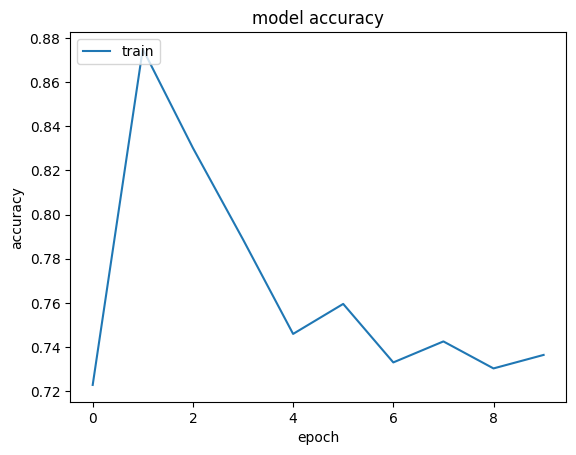

In [33]:
import matplotlib.pyplot as plt

epochs = 10
trained = model.fit(training_dataset, epochs=epochs)

def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train"], loc="upper left")
    plt.show()
    
plot_hist(trained)